### packages

In [1]:
import sys
import os
os.getcwd()

'c:\\Users\\ebaca\\Desktop\\CMD Research\\CMD Remote Repository\\autoencoder practice'

In [2]:
'''importing packages & necessary functions'''

# pytorch functionalities
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

# data processing
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# plotting & visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

# others
import tqdm
import numpy as np
import webp
from IPython.display import clear_output

sys.path.append('..')
from functions import net

# gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### notes

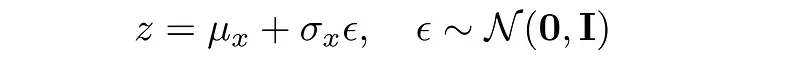

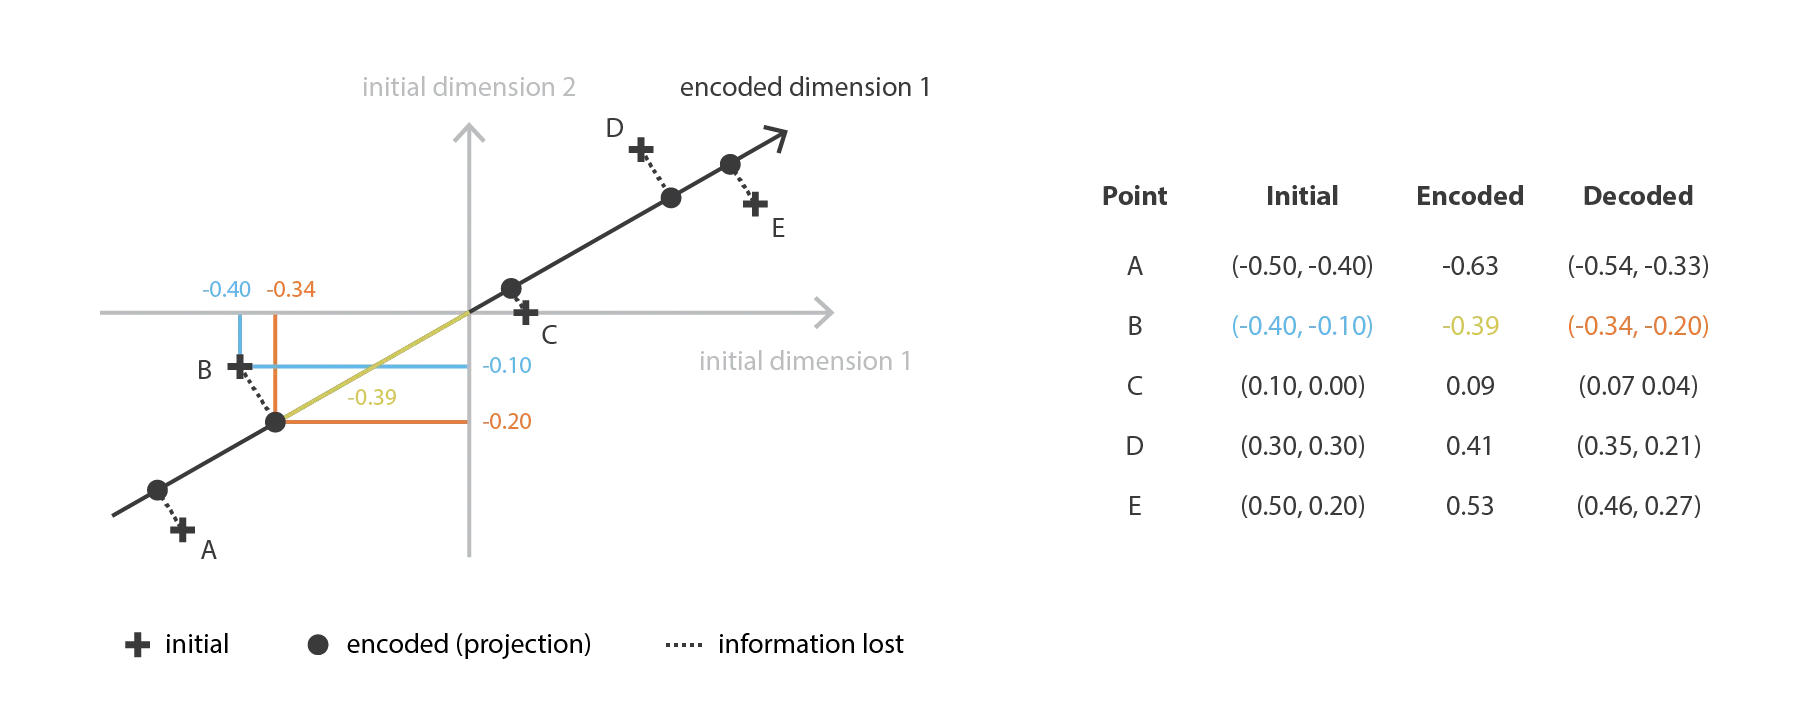

In [3]:
display(webp.load_image('../images/vae latent vector formula.webp'), 
        webp.load_image('../images/latent space visual.webp'))

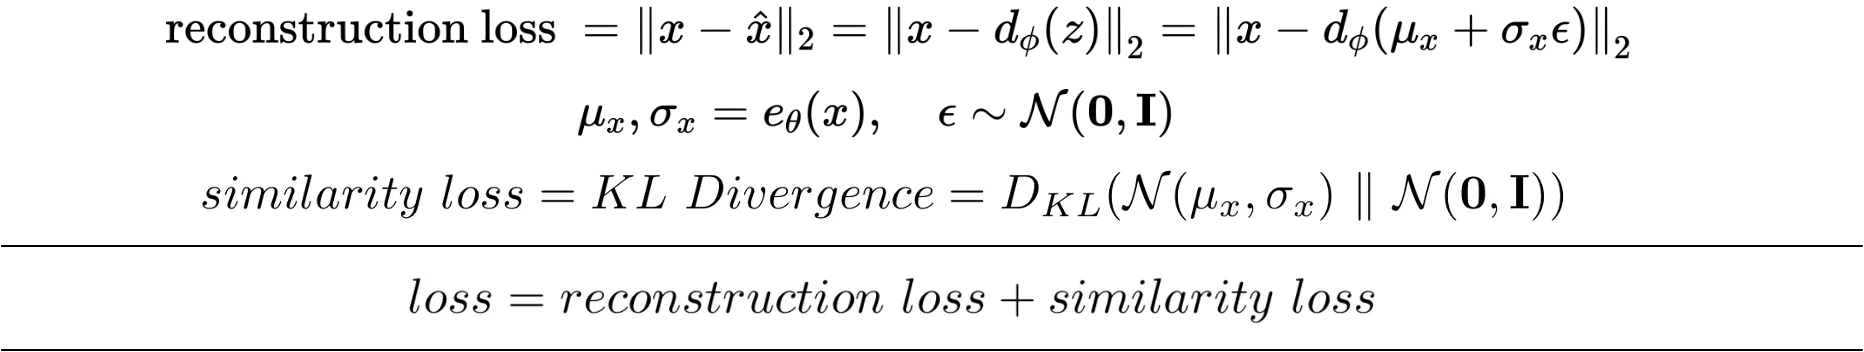

In [4]:
display(webp.load_image('../images/loss explained.webp'))

### gather data

In [5]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '../../Local Data Files/MNIST'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)
# using the same data as testing since we are trying to reproduce the images
print(type(train_dataset))

# 80-20 train-val split
n_train = int(0.8*len(train_dataset))
n_val = len(train_dataset) - n_train
train_dataset, val_dataset = random_split(train_dataset, [n_train, n_val], generator=np.random.seed(0))
print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}, Test dataset size: {len(test_dataset)}")
print(f"Image size: {train_dataset[0][0].size()}")

# create train, validation and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

<class 'torchvision.datasets.mnist.MNIST'>
Train dataset size: 48000, Validation dataset size: 12000, Test dataset size: 60000
Image size: torch.Size([1, 28, 28])


In [6]:
train_loader.dataset[0][0].size()[1], len(train_loader.dataset)

(28, 48000)

### building architecture

reference: [debugger cafe](https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/)

In [7]:
class ConvEncoder(nn.Module):
    def __init__(self, image_channels, init_channels, kernel_size, padding, latent_dim, leak, drop):
        super(ConvEncoder, self).__init__()

        self.init_ch_x2 = init_channels * 2        # 16
        self.init_ch_x4 = init_channels * 4        # 32
        self.init_ch_x8 = init_channels * 8        # 64
        self.init_ch_x16= init_channels * 16       # 128

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, init_channels, kernel_size=kernel_size, stride=2, padding=padding),
            nn.LeakyReLU(leak),
            nn.Conv2d(init_channels, self.init_ch_x2, kernel_size=kernel_size, stride=2, padding=padding),
            nn.LeakyReLU(leak),
            nn.Conv2d(self.init_ch_x2, self.init_ch_x4, kernel_size=kernel_size, stride=2, padding=padding),
            nn.LeakyReLU(leak),
            nn.Conv2d(self.init_ch_x4, self.init_ch_x8, kernel_size=kernel_size, stride=2, padding=0),
            nn.Flatten(),
            nn.Dropout(drop)
        )

        self.fc = nn.Linear(self.init_ch_x8, self.init_ch_x16)
        self.fc_mean = nn.Linear(self.init_ch_x16, latent_dim) 
        self.fc_var = nn.Linear(self.init_ch_x16, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        mean = self.fc_mean(x)
        variance = self.fc_var(x)
        return mean, variance


class ConvDecoder(nn.Module):
    def __init__(self, image_channels, init_channels, kernel_size, padding, latent_dim, leak, drop):
        super(ConvDecoder, self).__init__()

        self.init_ch_x2 = init_channels * 2        # 16
        self.init_ch_x4 = init_channels * 4        # 32
        self.init_ch_x8 = init_channels * 8        # 64
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.init_ch_x8, self.init_ch_x8, kernel_size=kernel_size, stride=2, padding=0),
            nn.LeakyReLU(leak),
            nn.ConvTranspose2d(self.init_ch_x8, self.init_ch_x4, kernel_size=kernel_size, stride=2, padding=padding),
            nn.LeakyReLU(leak),
            nn.ConvTranspose2d(self.init_ch_x4, self.init_ch_x2, kernel_size=kernel_size, stride=2, padding=padding),
            nn.LeakyReLU(leak),
            nn.ConvTranspose2d(self.init_ch_x2, image_channels, kernel_size=kernel_size, stride=2, padding=padding),
            nn.Sigmoid()
        )

        self.fc = nn.Linear(latent_dim, self.init_ch_x8)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.init_ch_x8, 1, 1) 
        x = self.decoder(x)
        return x


class ConvVAE(nn.Module):
    def __init__(self, image_channels=1, init_channels=8, kernel_size=4, padding=1, latent_dim=16, leak=0.8, drop=0.03, stochastic=True):
        super(ConvVAE, self).__init__()

        self.latent_dim = latent_dim
        self.stochastic = stochastic

        self.encoder = ConvEncoder(
                                    image_channels=image_channels, 
                                    init_channels=init_channels, 
                                    kernel_size=kernel_size,
                                    padding=padding,
                                    latent_dim=latent_dim, 
                                    leak=leak, drop=drop
                                ).to(device)
        self.decoder = ConvDecoder(
                                    image_channels=image_channels, 
                                    init_channels=init_channels, 
                                    kernel_size=kernel_size,
                                    padding=padding,
                                    latent_dim=latent_dim, 
                                    leak=leak, drop=drop
                                ).to(device)
    
    def reparameterize(self, mean, variance):
        if self.stochastic:
            stdev = torch.randn_like(variance).to(device)
            return mean + variance * stdev
        else:
            return mean

    def forward(self, x):
        x = x.to(device)
        mean, variance = self.encoder(x)
        z_sample = self.reparameterize(mean, variance)
        z = self.decoder(z_sample)
        return z, mean, variance

### initialize & train

In [8]:
def loss_function(x, x_hat, mean, log_var, kl_weight=1):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    # loss = reconstruction loss + similarity loss (KL divergence)
    return reproduction_loss + kl_weight*KLD

In [9]:
print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}, Test dataset size: {len(test_dataset)}")
print(f'Batch Size: {batch_size}')

print(f"Image size: {train_dataset[0][0].size()}")
# compressed image size: 28x28 = 784
img_size = train_dataset[0][0].size()[1]*train_dataset[0][0].size()[2] 
print(f"Compressed Image Size: {img_size}")

Train dataset size: 48000, Validation dataset size: 12000, Test dataset size: 60000
Batch Size: 100
Image size: torch.Size([1, 28, 28])
Compressed Image Size: 784


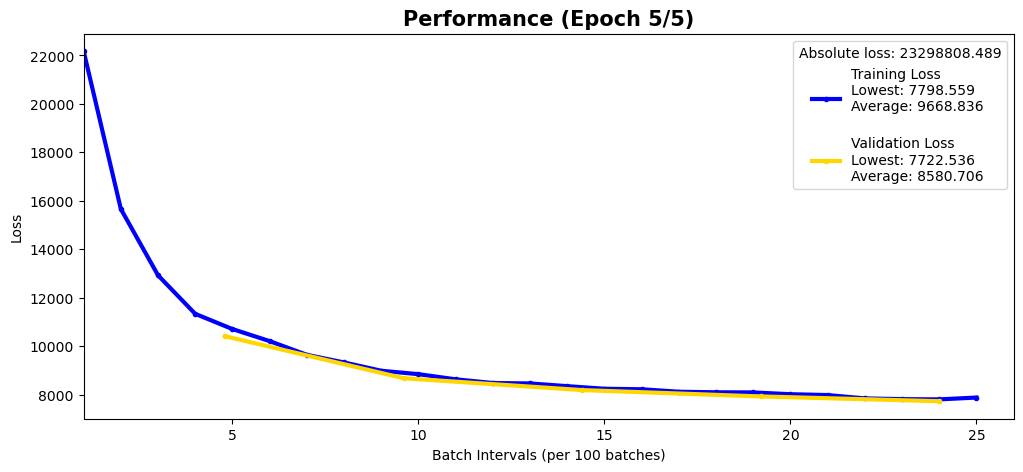

[07/09/24 17:38:02] (0.24) | Epoch: 1 | Batch: 0 | Learning Rate: 0.001 | KL Weight: 1 | Loss: 53301.55078125
[07/09/24 17:38:02] (0.35) | Epoch: 1 | Batch: 1 | Learning Rate: 0.001 | KL Weight: 1 | Loss: 52205.140625
[07/09/24 17:38:02] (0.39) | Epoch: 1 | Batch: 2 | Learning Rate: 0.001 | KL Weight: 1 | Loss: 48289.3984375
[07/09/24 17:38:02] (0.44) | Epoch: 1 | Batch: 3 | Learning Rate: 0.001 | KL Weight: 1 | Loss: 36981.82421875
[07/09/24 17:38:02] (0.48) | Epoch: 1 | Batch: 4 | Learning Rate: 0.001 | KL Weight: 1 | Loss: 42291.48828125
[07/09/24 17:38:02] (0.52) | Epoch: 1 | Batch: 5 | Learning Rate: 0.001 | KL Weight: 1 | Loss: 30903.798828125
[07/09/24 17:38:02] (0.55) | Epoch: 1 | Batch: 6 | Learning Rate: 0.001 | KL Weight: 1 | Loss: 30814.978515625
[07/09/24 17:38:02] (0.59) | Epoch: 1 | Batch: 7 | Learning Rate: 0.001 | KL Weight: 1 | Loss: 31378.814453125
[07/09/24 17:38:02] (0.62) | Epoch: 1 | Batch: 8 | Learning Rate: 0.001 | KL Weight: 1 | Loss: 29389.28125
[07/09/24 17:

23298808.489257812

In [10]:
model = ConvVAE(
            image_channels=1,  # setting to 1 since the images are grayscale
            init_channels=8, 
            kernel_size=14,
            padding=12,
            latent_dim=32, 
            leak=0.99, drop=0.01,
            stochastic=True
        ).to(device)
nnet = net(model, train_loader, val_loader, test_loader, batch_size, linear=False);

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-10);

nnet.train(optimizer=optimizer, lsfn=loss_function, epochs=5, live_plot=True, view_interval=100, kl_weight=1, averaging=True)

### evaluate

Accuracy: 0.890


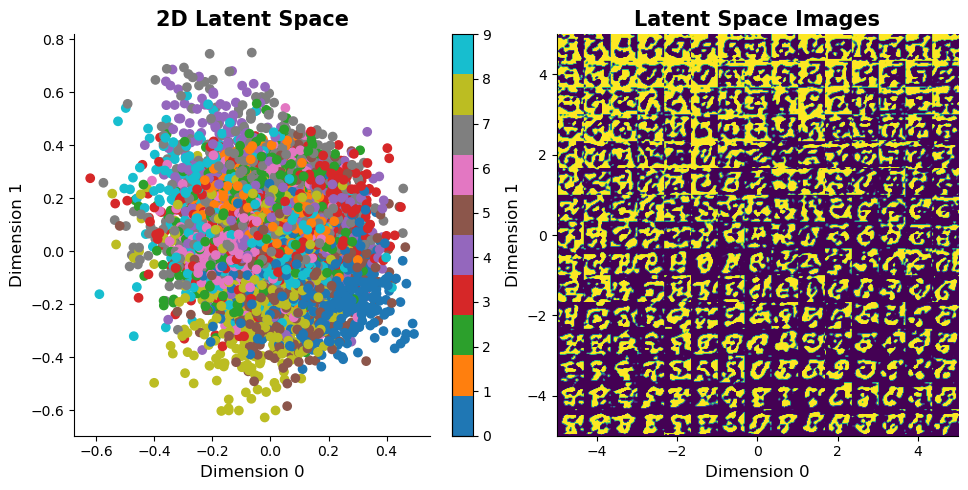

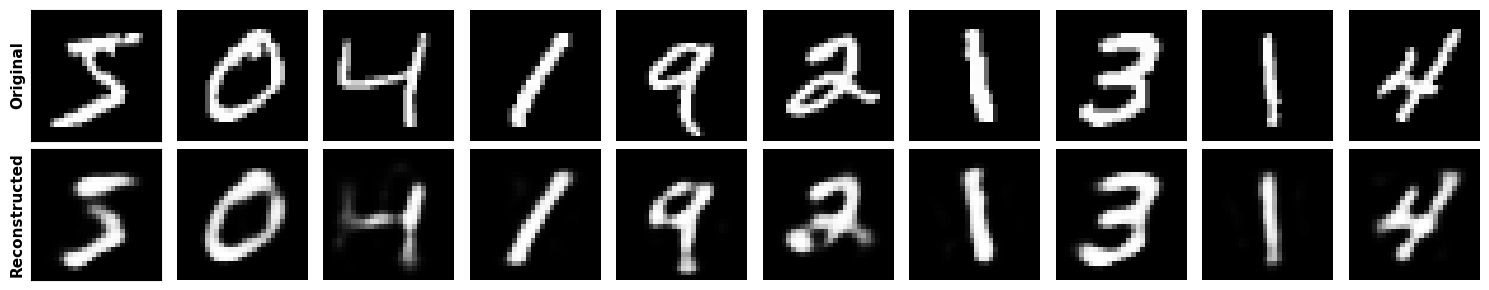

In [11]:
nnet.evaluate(test_loader)

latent_dims = (0, 1)

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
nnet.plat(test_loader, latent_dims) 
sns.despine()

plt.subplot(1, 2, 2)
nnet.prec(test_dataset, n=15, rangex=(-5, 5), rangey=(-5, 5), latent_dims=latent_dims)
sns.despine()

nnet.pgen(test_loader, num_images=10)